In [14]:
import numpy as np
import simulator
import csv
import subprocess
import pandas as pd
import os
import matplotlib.pyplot as plt

In [6]:
genotype_dict = {"0/0" : 0,
                "0/1" : 1,
                "1/0" : 1,
                "1/1" : 2,
                "0/." : 0,
                "./0" : 0,
                "1/." : 2,
                "./1" : 2,
                "./." : -1}
def compare_VCF_cells(real_f, inferred_f, n_sites):
    real_f.seek(0)
    inferred_f.seek(0)
    true_reader = list(csv.reader(real_f, delimiter='\t'))
    call_reader = list(csv.reader(inferred_f, delimiter='\t'))
    #Cells
    TP = FN = TN = FP = 0
    for i, field in enumerate(true_reader[0]):
        if field in genotype_dict.keys():
            first_cell_col_t = i
            break
    for i, field in enumerate(call_reader[0]):
        if field in genotype_dict.keys():
            first_cell_col_c = i
            break
    m = len(true_reader[0]) - first_cell_col_t
    for true_line in true_reader:
        found = False
        for call_line in call_reader:
            if call_line[0] == true_line[0] and call_line[1] == true_line[1]:
                #Correct site call found
                found = True
                for i in range(m):
                    if genotype_dict[true_line[first_cell_col_t + i]] > 0:
                        #Cell is really mutant
                        if genotype_dict[call_line[first_cell_col_c + i]] > 0:
                            #And called correctly
                            TP += 1
                        else:
                            #Real mutant not called
                            FN += 1
                    else:
                        #Cell is welltype
                        if genotype_dict[call_line[first_cell_col_c + i]] > 0:
                            #But called as mutant
                            FP += 1
                        else:
                            #Real wt called as wt
                            TN += 1
                break
        if not found:
            # Site mutant but not called
            for i in range(m):
                if genotype_dict[true_line[first_cell_col_t + i]] > 0:
                    #Cell actually mutant
                    FN += 1
                else:
                    TN += 1
    for call_line in call_reader:
        found = False
        for true_line in true_reader:
            if call_line[0] == true_line[0] and call_line[1] == call_line[1]:
                #Already dealt with correctly called sites above
                found = True
                break
        #Site called with no real mutation
        if not found:
            for i in range(m):
                if genotype_dict[call_line[first_cell_col_c + i]] > 0:
                    #Cell called mutant
                    FP += 1
    TN = m * n_sites - TP - FP - FN
    precision = TP/(TP + FP)
    recall    = TP/(TP + FN)
    F1        = (2*TP)/(2*TP + FP + FN)
    return (precision, recall, F1)

In [7]:
def test_phylo(m_cells, iters, params):
    cell_results = pd.DataFrame(columns=["i","Phylo","Precision","Recall","F1"])
    for i in range(iters):
        T = simulator.Phylogeny()
        T.evolve(n_generations=1000, germline=True)
        T.evolve(n_cells=5, germline=False)
        m = len(T.active_nodes)
        T.prepare()
        vcf_f = open("temp_r.vcf", "w+")
        T.write_vcf(vcf_f)
        vcf_f.close()
        pfile = open("temp.pileup", "w+")
        T.write_pileup(pfile)
        pfile.close()
        args = ["../SCarborSNV", "-m", str(m),"-p", "temp.pileup", "-o" "temp_c.vcf"]
        for name, val in params.items():
            args.append("--{}={}".format(name, val))
        subprocess.run(args)
        real_vcf = open("temp_r.vcf", "r")
        call_vcf = open("temp_c.vcf", "r")
        cell_results.loc[2*i] = [i, 'Y', *compare_VCF_cells(real_vcf, call_vcf, 2000)]
        real_vcf.close()
        call_vcf.close()
        args.append("--omit-phlo-inference")
        subprocess.run(args)
        real_vcf = open("temp_r.vcf", "r")
        call_vcf = open("temp_c.vcf", "r")
        cell_results.loc[2*i + 1] = [i, 'N', *compare_VCF_cells(real_vcf, call_vcf, 2000)]
        real_vcf.close()
        call_vcf.close()
    os.remove("temp.pileup")
    os.remove("temp_r.vcf")
    os.remove("temp_c.vcf")
    return cell_results

In [11]:
cell_results = test_phylo(10, 5, {"posterior-threshold":0})

In [12]:
cell_results.groupby(['Phylo']).mean()

,Precision,Recall,F1
Phylo,,,
N,0.681363,0.885110,0.737355
Y,0.650788,0.926598,0.731590


In [40]:
#Bigger analysis on other machine. candidate thresh was 0.5, 1000 pregenerations Trees with 10 leaves
#With second thresh
cell_results = pd.read_csv("phylo_cell_results.csv")
g1 = cell_results.loc[cell_results.Phylo == 'Y']
g2 = cell_results.loc[cell_results.Phylo == 'N']
g1.F1.mean()

0.867272165204473

(0.8, 1.005)

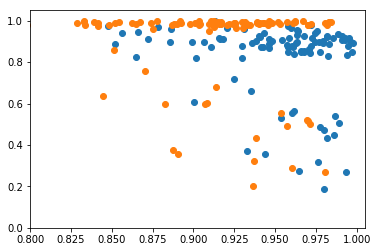

In [47]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(g1['Recall'], g1['Precision'])
ax.scatter(g2['Recall'], g2['Precision'])
ax.set_ylim([0,1.05])
ax.set_xlim([0.8,1.005])
#ax.set_yscale('log')
#ax.set_xscale('log')